# Time-series Prediction using MLP & LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# From: https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

## Datetime parser

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

## Load dataset

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Dataset/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

## Plot dataset

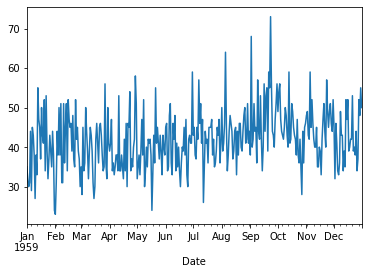

In [ ]:
dataset.plot()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

## Processing Time-series Data

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

# Baseline model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1474 - val_loss: 0.0920
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1443 - val_loss: 0.0898
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1416 - val_loss: 0.0879
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1391 - val_loss: 0.0863
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1370 - val_loss: 0.0850
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1351 - val_loss: 0.0838
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.0826
Epoch 8/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1319 - val_loss: 0.0816
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1305 - val_loss: 0.0807
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1293 - val_loss: 0.0799
Epoch 11/1000
9/9 

In [ ]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0694
Test loss: 0.06941196322441101


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
945,0.110776,0.069397,945
71,0.111119,0.069397,71
605,0.110797,0.069397,605
153,0.110803,0.069397,153
863,0.110775,0.069397,863
...,...,...,...
4,0.136999,0.084956,4
3,0.139112,0.086325,3
2,0.141570,0.087867,2
1,0.144329,0.089800,1


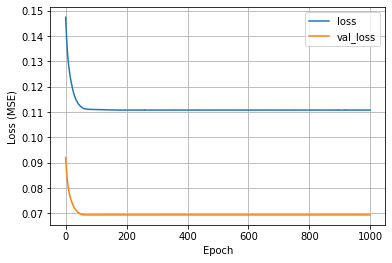

In [ ]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1166 - val_loss: 0.0753
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1124 - val_loss: 0.0726
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.0705
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1080 - val_loss: 0.0692
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.0684
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1056 - val_loss: 0.0678
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1049 - val_loss: 0.0673
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1043 - val_loss: 0.0669
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1039 - val_loss: 0.0666
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1035 - val_loss: 0.0663
Epoch 11/1000
9/9 

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
212,0.087367,0.056733,212
231,0.087327,0.056734,231
213,0.087263,0.056735,213
219,0.087372,0.056736,219
222,0.087388,0.056737,222
...,...,...,...
4,0.106499,0.068363,4
3,0.107973,0.069202,3
2,0.109964,0.070547,2
1,0.112364,0.072586,1


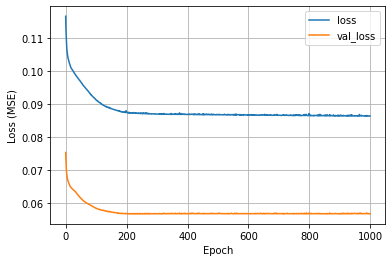

In [ ]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1081 - val_loss: 0.0613
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0962 - val_loss: 0.0567
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0544
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0540
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0542
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0547
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0818 - val_loss: 0.0550
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0552
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0814 - val_loss: 0.0552
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0814 - val_loss: 0.0551
Epoch 11/1000
9/9 

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
3,0.084666,0.053976,3
4,0.083441,0.054209,4
2,0.089488,0.054447,2
95,0.080667,0.054475,95
46,0.080691,0.054490,46
...,...,...,...
888,0.080091,0.055767,888
479,0.080251,0.055827,479
842,0.080374,0.055865,842
1,0.096185,0.056680,1


# LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 0.1136 - val_loss: 0.0702
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.0687
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1086 - val_loss: 0.0675
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1068 - val_loss: 0.0666
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1053 - val_loss: 0.0658
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1038 - val_loss: 0.0649
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1024 - val_loss: 0.0641
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.0634
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0996 - val_loss: 0.0626
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0981 - val_loss: 0.0618
Epoch 11/1000
9/9 

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
227,0.080530,0.054212,227
119,0.080533,0.054298,119
70,0.080555,0.054302,70
120,0.080502,0.054319,120
284,0.080472,0.054322,284
...,...,...,...
4,0.105304,0.065789,4
3,0.106810,0.066604,3
2,0.108611,0.067545,2
1,0.110828,0.068692,1


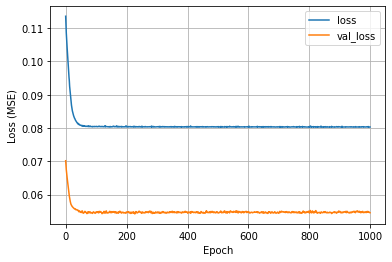

In [ ]:
plot_loss(lstm_model_history)

BASELINE (loss : 0.110776,	val_loss : 0.069397,	epoch : 945)

DEEPER MODEL(loss : 0.087367, val_loss : 0.056733, epochs :	212

WIDER MODEL(loss : 0.084666, val_loss :	0.053976, epochs : 3)

LSTM(loss : 0.080530, val_loss : 0.054212, epochs :	227)

Kesimpulan : nilai loss terendah yaitu pada model LSTM, nilai val_loss terendah ada pada wider model.  Namun, untuk val_loss LSTM juga tidak jauh berbeda dengan wider model. Sehingga kedua model ini merupakan model terbaik